In [1]:
%matplotlib inline
import sys, os
sys.path.append("../")
import numpy as np
import scipy as sp
import numpy.linalg as nla
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import timeit
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from drot.solver import drot, sinkhorn
from drot.proximal import *
import csv
%load_ext autoreload
%autoreload 2

# Optimal transport

In [9]:
def save(C, nrows, ncols, filename):
    assert C.flags['F_CONTIGUOUS']   
    output_file = open(filename, 'wb')
    C.tofile(output_file)
    output_file.close()

def two_dimensional_gaussian_ot(m, n):
    d = 2
    mu_s = np.random.normal(0.0, 1.0, (d,)) # Gaussian mean
    A_s = np.random.rand(d, d)
    cov_s = np.dot(A_s, A_s.transpose()) # Gaussian covariance matrix
    mu_t = np.random.normal(5.0, 5.0, (d,))
    A_t = np.random.rand(d, d)
    cov_t = np.dot(A_t, A_t.transpose())
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((m,)) / m, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()
    return m, n, C, p, q

In [160]:
def multi_experiment(m, n, max_iters, accuracies, skregs, alpha=2.0, ntests=10):
    num_accuracies = accuracies.shape[0]
    num_algs = skregs.shape[0] + 1
    outs = np.zeros([num_algs, 1, num_accuracies, ntests])
    
    for test_idx in range(ntests):
        print("\n *** Experiment", test_idx+1, "of", ntests, "***")
        
        m, n, C, p, q = two_dimensional_gaussian_ot(m, n)
        x0 = np.array(np.outer(p, q), order = 'F')
        step = alpha / (m+n)
        
        C_ = C.copy()
        optval = ot.emd2(p, q, C_, numItermax=1_000_000)
        
        drout = drot(x0, C, p, q, max_iters=max_iters, step=step, compute_r_primal=True, 
                    compute_r_dual=False, eps_abs=1e-4, eps_rel=0.0)
        
        skout = []                        
        for reg in skregs:
            skout.append(ot.sinkhorn(p, q, C_, reg, numItermax=max_iters, stopThr=7e-5))
        
        outs[0, 0, :, test_idx] = abs(np.sum(drout['sol']*C) - optval) / optval
        for sk_idx in range(skregs.shape[0]):
           outs[sk_idx+1, 0, :, test_idx] = abs(np.sum(skout[sk_idx]*C_) - optval) / optval

    file_name = 'Dims_' + str(m) + '_test_' + str(ntests)
    np.save('output/'+file_name + '.npy', outs)
    return file_name

def profile(dir, accuracies, labels, colors):     
    outs = np.load(dir)
    (num_algs, num_objs_computed, num_accuracies, ntests) = outs.shape
    performance_ratio = np.zeros((num_algs, num_accuracies))
    
    for alg_idx in range(num_algs):
        for acc_idx in range(num_accuracies):
            performance_ratio[alg_idx, acc_idx] = np.sum((outs[alg_idx, 0, acc_idx, :] <= accuracies[acc_idx])) / ntests

    fig = plt.figure()        
    for alg_idx in range(num_algs):
        plt.plot(accuracies, performance_ratio[alg_idx, :], color=colors[alg_idx], label=labels[alg_idx], linewidth=2.5)
  
    ylabel = r'Performance ratio'
    plt.xlabel(r'Accuracy')
    plt.ylabel(ylabel)
    plt.xscale('log')
    # plt.xlim(1e-4, 1e-1)
    plt.legend()
        
    return fig

In [161]:
m, n = 512, 512
max_iters = 1000
accuracies = np.logspace(-4.5, -1, num=15)
skregs = np.array([1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])

file_name = multi_experiment(m, n, max_iters, accuracies, skregs, ntests=100)


 *** Experiment 1 of 100 ***
Drot terminated at iteration  999

 *** Experiment 2 of 100 ***


/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: divide by zero encountered in true_divide
  v = np.divide(b, KtransposeU)
/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


Drot terminated at iteration  922

 *** Experiment 3 of 100 ***
Drot terminated at iteration  694

 *** Experiment 4 of 100 ***


/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:364: RuntimeWarning: divide by zero encountered in true_divide
  u = 1. / np.dot(Kp, v)
/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:364: RuntimeWarning: overflow encountered in true_divide
  u = 1. / np.dot(Kp, v)


Drot terminated at iteration  999

 *** Experiment 5 of 100 ***
Drot terminated at iteration  670

 *** Experiment 6 of 100 ***
Drot terminated at iteration  933

 *** Experiment 7 of 100 ***
Drot terminated at iteration  723

 *** Experiment 8 of 100 ***
Drot terminated at iteration  922

 *** Experiment 9 of 100 ***
Drot terminated at iteration  999

 *** Experiment 10 of 100 ***
Drot terminated at iteration  862

 *** Experiment 11 of 100 ***
Drot terminated at iteration  999

 *** Experiment 12 of 100 ***
Drot terminated at iteration  999

 *** Experiment 13 of 100 ***
Drot terminated at iteration  999

 *** Experiment 14 of 100 ***
Drot terminated at iteration  716

 *** Experiment 15 of 100 ***
Drot terminated at iteration  565

 *** Experiment 16 of 100 ***
Drot terminated at iteration  999

 *** Experiment 17 of 100 ***
Drot terminated at iteration  957

 *** Experiment 18 of 100 ***
Drot terminated at iteration  635

 *** Experiment 19 of 100 ***
Drot terminated at iteration  

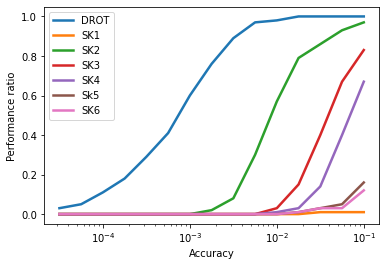

In [162]:
labels = ['DROT', 'SK1', 'SK2', 'SK3', 'SK4', 'Sk5', 'SK6']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
dir = "output/" + file_name  + '.npy'
fig = profile(dir, accuracies, labels, colors)

# fig.savefig('figures/'+ file_name + '_mean_1_f64.eps', format='eps')

## Single problem

In [66]:

m, n, C, p, q = two_dimensional_gaussian_ot(512, 512)
C_ = C.copy()
G0 = ot.emd(p, q, C_, numItermax=1_000_000)
Gsk = ot.sinkhorn(p, q, C_, 1e-3, numItermax=1000, stopThr=1e-5)
Gsb = ot.bregman.sinkhorn_stabilized(p, q, C_, 1e-3, umItermax=1000, stopThr=1e-5)
femd, fsk, fsb = np.sum(G0*C_), np.sum(Gsk*C_), np.sum(Gsb*C_)

Drot terminated at iteration  11


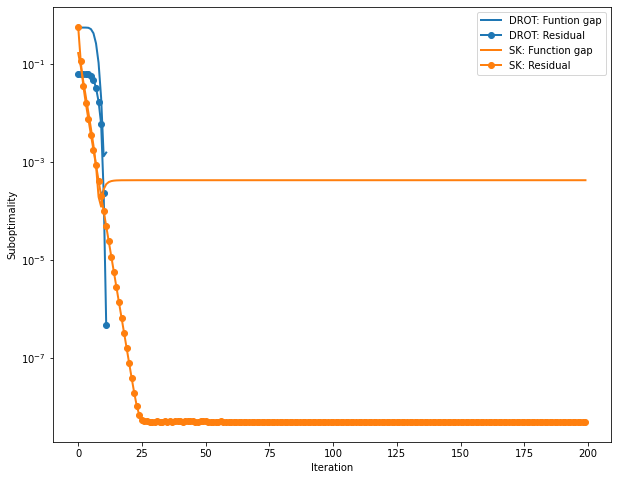

In [72]:
x0 = np.array(np.outer(p, q), order = 'F')
max_iters = 500
step = .051 / (m+n)

drout  = drot(x0, C, p, q, max_iters=max_iters, step=step, compute_r_primal=True, 
              compute_r_dual=True, eps_abs=1e-5, verbose=False, print_every=100)
xopt = drout["sol"]
skout, log = sinkhorn(p, q, C_, 1e-3, numItermax=200, stopThr=1e-15)
optval = femd

plt.figure(1, figsize=(10,8))
plt.plot(range(drout["num_iters"]), [ abs(f-optval) for f in drout['dual']], color='C0', label='DROT: Funtion gap', linewidth=2)
plt.plot(range(drout["num_iters"]), [r for r in drout['primal']], color='C0', marker='o', label='DROT: Residual', linewidth=2)
plt.plot([k for k in log['iter']], [ abs(f - optval) for f in log['fval']], color='C1', label='SK: Function gap', linewidth=2)
plt.plot([k for k in log['iter']], [ r for r in log['res']], color='C1',  marker='o', label='SK: Residual', linewidth=2)

plt.xlabel("Iteration") 
plt.ylabel("Suboptimality") 
plt.yscale('log')
plt.legend()

### Sparsity of the approximate solutions

In [116]:
np.sum(xopt > 0) / (m*n), np.sum(G0 > 0) / (m*n), np.sum(Gsk > 0) / (m*n), np.sum(Gsb > 0) / (m*n)

(0.2523460388183594, 0.001953125, 0.9859619140625, 1.0)

Text(0.5, 1.0, 'OT matrix Sinkhorn')

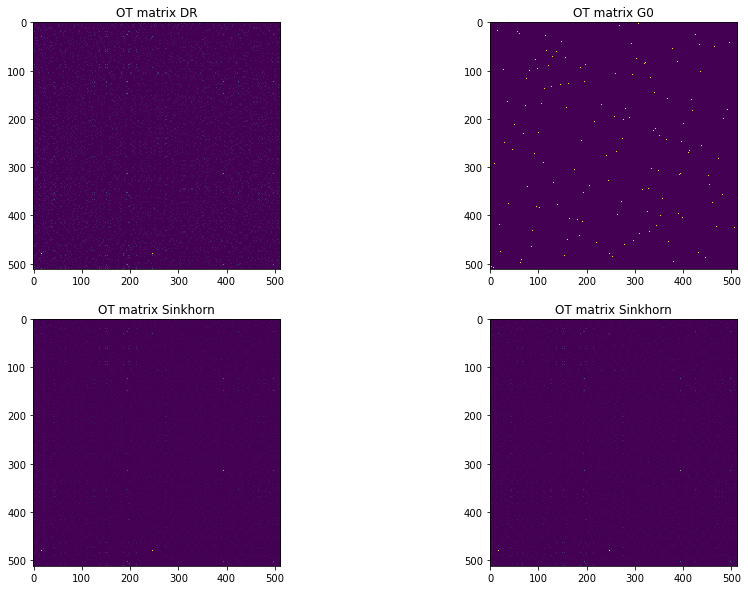

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(xopt, interpolation='nearest')
axs[0, 0].set_title('OT matrix DR')

axs[0, 1].imshow(G0, interpolation='nearest')
axs[0, 1].set_title('OT matrix G0')

axs[1, 0].imshow(Gsk, interpolation='nearest')
axs[1, 0].set_title('OT matrix Sinkhorn')

axs[1, 1].imshow(Gsk, interpolation='nearest')
axs[1, 1].set_title('OT matrix Sinkhorn')